# News topic classification tasks

## packages

In [ ]:
import torch
import torchtext
import os
from keras.preprocessing.text import Tokenizer
from keras_preprocessing import sequence
import string
import re
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
import time
from torch.utils.data import DataLoader

## Download the data

We're going to use torchtext.datasets.AG_NEWS,there are four types of news inside.

In [ ]:
load_data_path = "../data"
 
if not os.path.isdir(load_data_path):
    os.mkdir(load_data_path)
    
train_dataset, test_dataset = torchtext.datasets.AG_NEWS(
    root='../data/', split=('train', 'test'))

We can have a look about the data.

In [ ]:
print(list(train_dataset)[:3])

**Basic information of the data:**

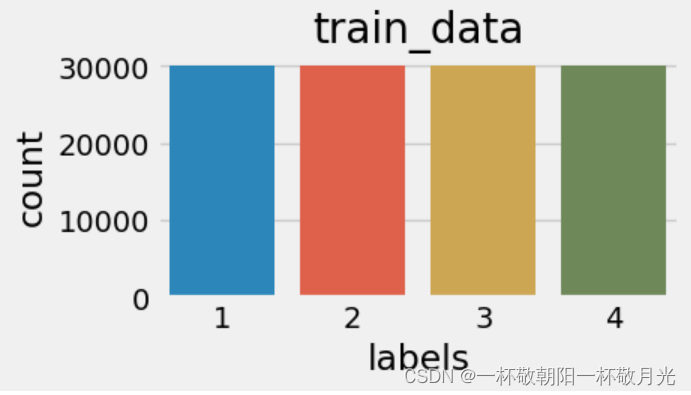

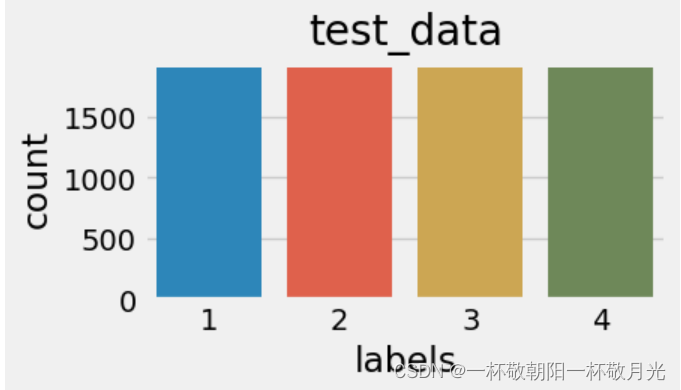

The training set has 120,000 samples, and the label has four values: 1, 2, 3, and 4. The distribution of various types of labels in the training set and test set is relatively uniform.

## Work with datasets

Function: 
1. Replace  with space (i.e., split the words on both sides of it into two words), convert all letters to lowercase. 
2. Convert the label to [0,3]. 
3. Sentence length interception

**The length of the sentences in the sample was analyzed: more than 90% of the sentences were not more than 50 in length, so 50 words were subsequently intercepted.**

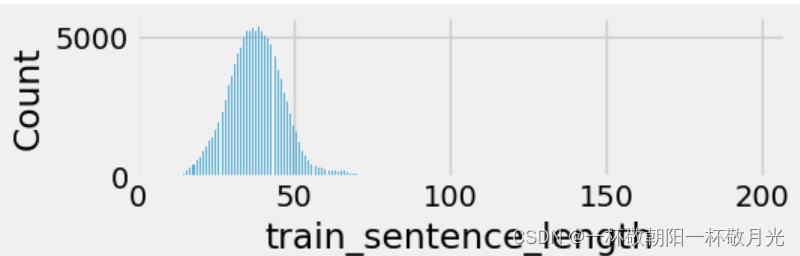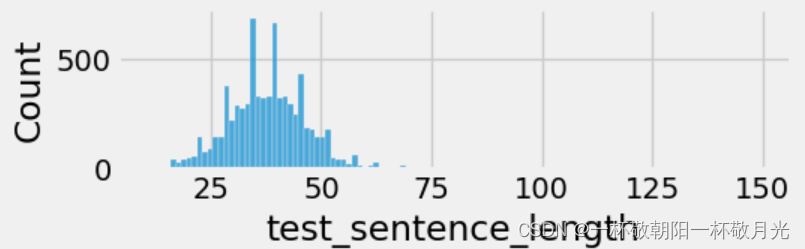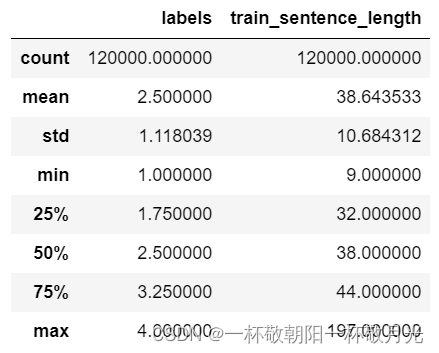

In [ ]:
punct  = str.maketrans('','',string.punctuation)
def process_datasets_by_Tokenizer(train_dataset, test_dataset, seq_len=200):
    """
    Parameter:
    Tran Dattaset: Training sample list Lister (Tapoel (Inter, Ster))
    Return:
    Tran Dattaset: Training set list Lister Petter (Tapul (Turner, Inter))
    """
    tokenizer = Tokenizer()
    train_dataset_texts, train_dataset_labels = [], []
    test_dataset_texts, test_dataset_labels = [], []
    
    for label, text in train_dataset:
        # In the previous print, you can see that there is "\\" , which is replaced with a space, and all of them are lowercase letters
        train_dataset_texts.append(text.replace('\\',' ').translate(punct).lower())
        train_dataset_labels.append(label - 1)  # Mapping Labels to [0,3]
        
    for label, text in test_dataset:
        test_dataset_texts.append(text.replace('\\',' ').translate(punct).lower())
        test_dataset_labels.append(label - 1)
    
    # Here's the trick and put the training set of tests together to build a vocabulary list, so that there are no unlogged words
    all_dataset_texts = train_dataset_texts + test_dataset_texts
    all_dataset_labels = train_dataset_labels + test_dataset_labels
    tokenizer.fit_on_texts(all_dataset_texts)
    
    #train_dataset_seqs is a list in which each element is a list that transforms a sentence from a literal representation into an index representation in a vocabulary
    train_dataset_seqs = tokenizer.texts_to_sequences(train_dataset_texts)
    test_datase_seqs = tokenizer.texts_to_sequences(test_dataset_texts)
    #print(type(train_dataset_seqs), type(train_dataset_seqs[0]))  # <class 'list'> <class 'list'>
    #print(train_dataset_seqs)
    
    # Intercept the first seq_len, and make up 0 after the shortage
    # train_dataset_seqs is a tensor，size:(Number of samples, seq_len)
    train_dataset_seqs = torch.tensor(sequence.pad_sequences(
        train_dataset_seqs, seq_len, padding='post'), dtype=torch.int32)
    test_datase_seqs = torch.tensor(sequence.pad_sequences(
        test_datase_seqs, seq_len, padding='post'), dtype=torch.int32)
    #print(type(train_dataset_seqs), type(train_dataset_seqs[0]))  # <class 'torch.Tensor'> <class 'torch.Tensor'>
    #print(train_dataset_seqs)
    
    train_dataset = list(zip(train_dataset_seqs, train_dataset_labels))
    test_dataset = list(zip(test_datase_seqs, test_dataset_labels))
    
    vocab_size = len(tokenizer.index_word.keys())
    num_class = len(set(all_dataset_labels))
    return train_dataset, test_dataset, vocab_size, num_class
 
 
embed_dim = 16  # There are about 90,000 words, and the embedding dimension here is 16
batch_size = 64
seq_len = 50  #  A sentence length of 50 can cover more than 90% of the sample
 
train_dataset, test_dataset, vocab_size, num_class = process_datasets_by_Tokenizer(
    train_dataset, test_dataset, seq_len=seq_len)
 
print(train_dataset[:2])
print("vocab_size = {}, num_class = {}".format(vocab_size, num_class))

With the 4 print statements commented out open, let's test the code:

In [ ]:
train = [(1, 'The moon is light'),
        (2, 'This is the last rose of summer')]
test = train[:]
train, test, sz, cls = process_datasets_by_Tokenizer(train, test, seq_len=5)
train, test, sz, cls

## Build a model

The structure of the model is simple: embedding layer + average pooling layer + fully connected layer

In [ ]:
class TextSentiment(nn.Module):
    """Text classification model"""
    def __init__(self, vocab_size, embed_dim, num_class, seq_len):
        """
        description: Initialization function of the class
        :param vocab_size: The total number of distinct words contained in the entire corpus
        :param embed_dim: Specifies the dimension in which the word is embedded
        :param num_class: The total number of categories for the text classification
        """ 
        super(TextSentiment, self).__init__()
        
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        
        # Instantiating the embedding layer, 
        #sparse=True means that only part of the weights are updated each time the gradient is solved for that layer.
        self.embedding = nn.Embedding(vocab_size, embed_dim, sparse=True)
        # Instantiate the linear layer, the parameters are embed_dim and num_class.
        self.fc = nn.Linear(embed_dim, num_class)
        # Initialize weights for each layer
        self.init_weights()
        
    def init_weights(self):
        """Initialize the weight function"""
        # Specifies the number of value ranges for the initial weight
        initrange = 0.5
        # The weight parameters of each layer are initialized to a uniform distribution
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        # The bias is initialized to 0
        self.fc.bias.data.zero_()
        
    def forward(self, text):
        """
        :param text: The result of the text numeric mapping
        :return: A tensor of the same size as the number of categories, which is used to determine the category of the text
        """
        # [batch_size, seq_len, embed_dim]
        embedded = self.embedding(text)  
        # [batch_size, embed_dim, seq_len]，
        # Later, the dimension where the sentence is located is pooling, so put the dimension where the sentence is located at the end
        embedded = embedded.transpose(2, 1) # The dimension of the sentence changes from the second dimension to the third dimension
        # [batch_size, embed_dim, 1] 
        embedded = F.avg_pool1d(embedded, kernel_size=self.seq_len)
        # [embed_dim, batch_size] 
        embedded = embedded.squeeze(-1)
        # [batch_size, embed_dim]
        # I saw that torch.nn.CrossEntropyLoss() comes with softmax, so I don't have softmax here
        return self.fc(embedded)

## Training

### generate_batch

generate_batch: Construct the data in a batch and pass it in as a parameter of the DataLoader function

In [ ]:
def generate_batch(batch):
    """[summary]
    Args:
        batch ([type]): [description] A batch_size-sized list of sample tensors and tuples of corresponding labels
            [(sample1, label1), (sample2, label2), ..., (samplen, labeln)]
    :return Sample tensors and labels are in their respective list forms(Tensor)
    """
    text = [entry[0].reshape(1, -1) for entry in batch]
#     print(text)
    label = torch.tensor([entry[1] for entry in batch])
    text = torch.cat(text, dim=0)
    
    return torch.tensor(text), torch.tensor(label)

Let's test the effect of this paragraph:

In [ ]:
batch = [(torch.tensor([3, 23, 2, 8]), 1), (torch.tensor([3, 45, 21, 6]), 0)]
res = generate_batch(batch)
print(res, res[0].size())

### Training & Validation Functions

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def run(data, batch_size, model, criterion, 
        mode='train', optimizer=None, scheduler=None):
    total_loss, total_acc = 0., 0.
    
    shuffle = False
    if mode == 'train':
        shuffle = True
    data = DataLoader(data, batch_size=batch_size, shuffle=shuffle,
                     collate_fn=generate_batch)
 
    for i, (text, label) in enumerate(data):
#         text = text.to(device)  # gpu version
#         label = label.to(device)
        sz = text.size(0)
        if mode == 'train':
            optimizer.zero_grad()
            output = model(text)
            loss = criterion(output, label)
            # Cumulative batch average, referring to the reservoir sampling algorithm
            total_loss = i / (i + 1) * total_loss + loss.item() / sz / (i + 1)
            loss.backward()
            optimizer.step()
#             predict = F.softmax(output, dim=-1)
            correct_cnt = (output.argmax(1) == label).sum().item()
            total_acc = i / (i + 1) * total_acc + correct_cnt / sz / (i + 1)
        else:
            with torch.no_grad():
                output = model(text)
                loss = criterion(output, label)
                total_loss = i / (i + 1) * total_loss + loss.item() / sz / (i + 1)
#                 predict = F.softmax(output, dim=-1)
                correct_cnt = (output.argmax(1) == label).sum().item()
                total_acc = i / (i + 1) * total_acc + correct_cnt / sz / (i + 1)
        
#         if i % 10 == 0:
#             print("i: {}, loss: {}".format(i, total_loss))
    
     # Adjust the optimizer learning rate
    if (scheduler):
        scheduler.step()
#     print(total_loss, total_acc, total_loss / count, total_acc / count, count)
    return total_loss , total_acc

### Main process

In [ ]:
model = TextSentiment(vocab_size + 1, embed_dim, num_class, seq_len)
# model = TextSentiment(vocab_size + 1, embed_dim, num_class, seq_len).to(device) # gpu version
 
criterion = torch.nn.CrossEntropyLoss()  # Comes with softmax
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
 
train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = random_split(train_dataset, 
                                      [train_len, len(train_dataset) - train_len])
n_epochs = 10
for epoch in range(n_epochs):
    start_time = time.time()
    train_loss, train_acc = run(sub_train_, batch_size, model, criterion, 
        mode='train', optimizer=optimizer, scheduler=scheduler)
    
    valid_loss, valid_acc = run(sub_train_, batch_size, model, criterion, mode='validation')
    
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    
    print("Epoch: %d" % (epoch + 1),
          " | time in %d minutes, %d seconds" % (mins, secs))
    print(
        f"\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)"
    )
    print(
        f"\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)"
    )